In [1]:
import numpy as np  # array operations
import pandas as pd  # time series management
from pandas_datareader import data as web  # data retrieval
import seaborn as sns; sns.set()  # nicer plotting style
import datetime

# put all plots in the notebook itself
%matplotlib inline

import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

/anaconda/envs/py3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/anaconda/envs/py3.4/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [10]:
start = datetime.datetime(2010,1,1)
end = datetime.date.today()

In [36]:
apple = web.DataReader("AAPL", "yahoo", start, end)

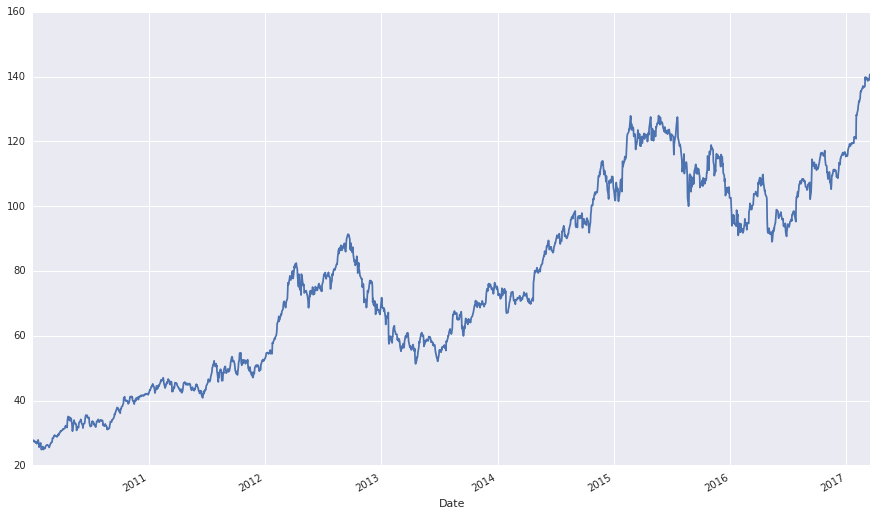

In [37]:
apple["Adj Close"].plot(grid = True)

In [38]:
apple["20d"] = np.round(apple["Adj Close"].rolling(window = 20, center = False).mean(), 2)
apple["50d"] = np.round(apple["Adj Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj Close"].rolling(window = 200, center = False).mean(), 2)

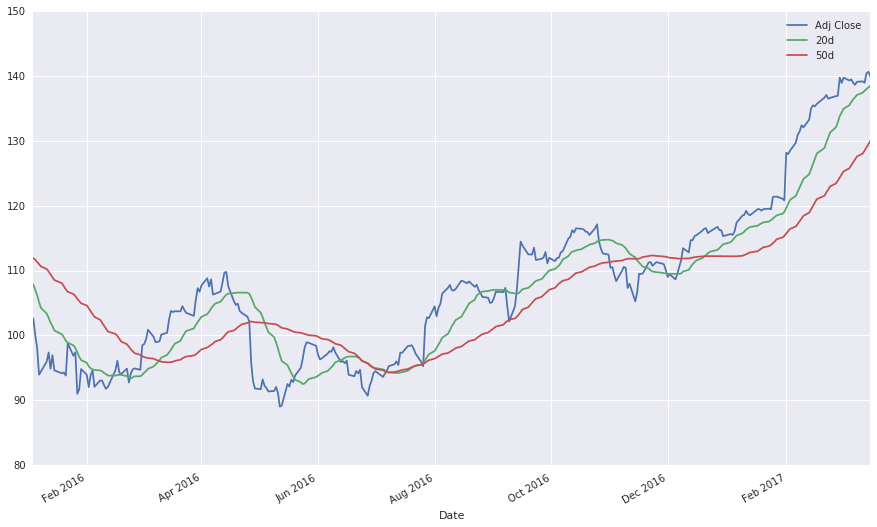

In [39]:
apple_16 = apple.loc['2016-01-01':'2017-03-19', :]
apple_16[["Adj Close", "20d", "50d"]].plot()


In [40]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d
Date,,,,,,,,,,
2017-03-13,138.850006,139.429993,138.820007,139.199997,17042400,139.199997,137.46,128.06,111.81,9.40
2017-03-14,139.300003,139.649994,138.839996,138.990005,15189700,138.990005,137.75,128.52,112.01,9.23
2017-03-15,139.410004,140.750000,139.029999,140.460007,25566800,140.460007,138.02,129.02,112.22,9.00
2017-03-16,140.720001,141.020004,140.259995,140.690002,19132500,140.690002,138.28,129.52,112.43,8.76
2017-03-17,141.000000,141.000000,139.889999,139.990005,43597400,139.990005,138.51,130.01,112.64,8.50


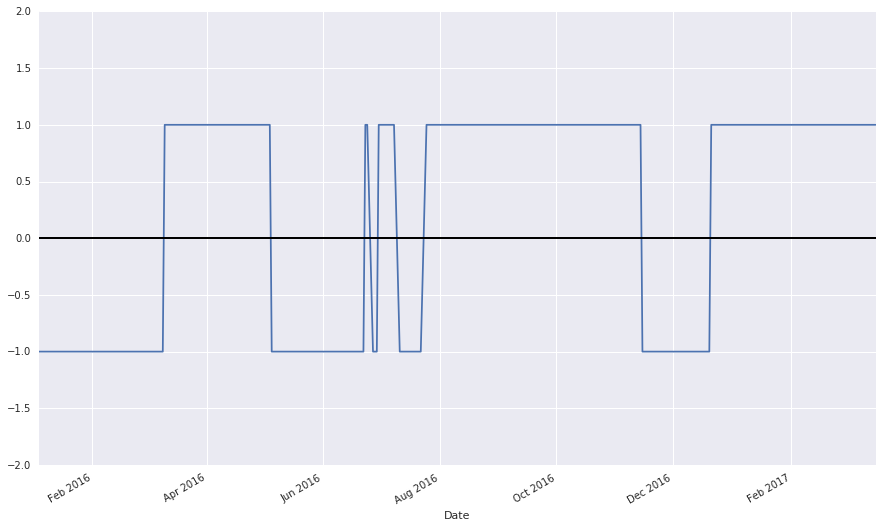

In [41]:
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-01':'2017-03-19',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [42]:
apple["Regime"].value_counts()

 1    1132
-1     627
 0      55
Name: Regime, dtype: int64

In [45]:
apple.loc['2016-01-01':'2017-03-19',"Regime"].value_counts()

 1    186
-1    118
Name: Regime, dtype: int64

Trading signals appear at regime changes. When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered (this is of interest only if you ever will short the stock, or use some derivative like a stock option to bet against the market).

It’s simple to obtain signals. Let r_t indicate the regime at time t, and s_t the signal at time t. Then:

s_t = sign(r_t - r_{t - 1}) 

s_t in {-1, 0, 1}, with -1 indicating “sell”, 1 indicating “buy”, and 0 no action. We can obtain signals like so:


In [46]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,200d,20d-50d,Regime,Signal
Date,,,,,,,,,,,,
2017-03-13,138.850006,139.429993,138.820007,139.199997,17042400,139.199997,137.46,128.06,111.81,9.40,1.0,0.0
2017-03-14,139.300003,139.649994,138.839996,138.990005,15189700,138.990005,137.75,128.52,112.01,9.23,1.0,0.0
2017-03-15,139.410004,140.750000,139.029999,140.460007,25566800,140.460007,138.02,129.02,112.22,9.00,1.0,0.0
2017-03-16,140.720001,141.020004,140.259995,140.690002,19132500,140.690002,138.28,129.52,112.43,8.76,1.0,0.0
2017-03-17,141.000000,141.000000,139.889999,139.990005,43597400,139.990005,138.51,130.01,112.64,8.50,1.0,-1.0


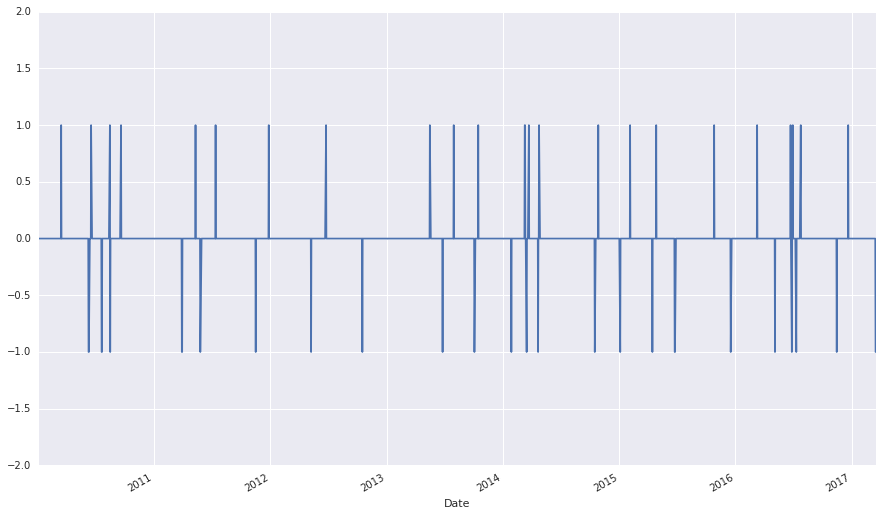

In [47]:
apple["Signal"].plot(ylim = (-2, 2))

In [48]:
apple.loc['2016-01-01':'2017-03-19',"Signal"].value_counts()

 0.0    294
-1.0      5
 1.0      5
Name: Signal, dtype: int64

In [50]:
apple["Signal"].value_counts()

 0.0    1762
-1.0      27
 1.0      24
Name: Signal, dtype: int64

In [51]:
# To identify what the prices of the stock is at every buy and every sell.
apple.loc[apple["Signal"] == 1, "Adj Close"]

Date
2010-03-16     29.079641
2010-06-18     35.508388
2010-08-16     32.084128
2010-09-20     36.695153
2011-05-12     44.901452
2011-07-14     46.352521
2011-12-28     52.165858
2012-06-25     73.948707
2013-05-17     57.338536
2013-07-31     59.888765
2013-10-16     66.755822
2014-03-11     72.262632
2014-03-12     72.332728
2014-03-24     72.680505
2014-04-25     77.095060
2014-10-28    101.782973
2015-02-05    115.319223
2015-04-28    125.530074
2015-10-27    111.097536
2016-03-10     99.075516
2016-06-23     94.683468
2016-06-30     94.190838
2016-07-25     95.905188
2016-12-21    116.554665
Name: Adj Close, dtype: float64

In [52]:
apple.loc[apple["Signal"] == -1, "Adj Close"]

Date
2010-06-10     32.455964
2010-06-11     32.844641
2010-07-21     32.939220
2010-07-22     33.558515
2010-08-17     32.645122
2011-03-30     45.168347
2011-03-31     45.152800
2011-05-27     43.714687
2011-11-17     48.897070
2012-05-09     73.742708
2012-10-17     83.873956
2013-06-26     52.681415
2013-10-04     64.347280
2014-01-28     67.867790
2014-03-17     71.002298
2014-04-22     71.670885
2014-10-17     93.134185
2015-01-05    101.755057
2015-04-16    121.309203
2015-06-25    123.100026
2015-06-26    122.375908
2015-12-18    103.274512
2016-05-05     91.865625
2016-06-27     90.683316
2016-07-11     95.550502
2016-11-15    106.647621
2017-03-17    139.990005
Name: Adj Close, dtype: float64

In [53]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,29.079641,1.0,Buy
2010-06-10,32.455964,0.0,Sell
2010-06-11,32.844641,-1.0,Sell
2010-06-18,35.508388,1.0,Buy
2010-07-21,32.939220,0.0,Sell
2010-07-22,33.558515,-1.0,Sell
2010-08-16,32.084128,0.0,Buy
2010-08-17,32.645122,-1.0,Sell
2010-09-20,36.695153,1.0,Buy


In [54]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple                           _signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-10,29.079641,3.376323
2010-06-18,2010-07-21,35.508388,-2.569168
2010-09-20,2011-03-30,36.695153,8.473194
2011-05-12,2011-05-27,44.901452,-1.186765
2011-07-14,2011-11-17,46.352521,2.544549
2011-12-28,2012-05-09,52.165858,21.576850
2012-06-25,2012-10-17,73.948707,9.925249
2013-05-17,2013-06-26,57.338536,-4.657121
2013-07-31,2013-10-04,59.888765,4.458515
